Detect Corner 

In [1]:
import cv2
import numpy as np

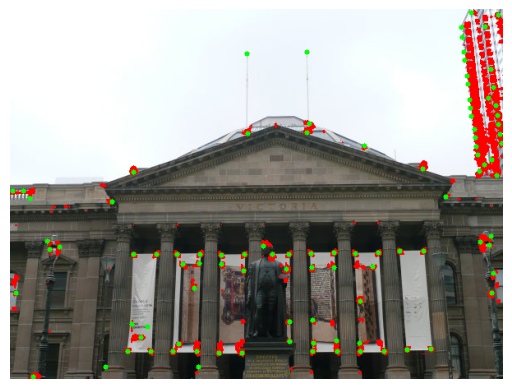

In [2]:
image_path= r"C:\Users\91744\Desktop\rbe 549\P1_starter_code\YourDirectoryID_p1\Phase1\Data\Train\Set1\1.jpg"
image_path2= r"C:\Users\91744\Desktop\rbe 549\P1_starter_code\YourDirectoryID_p1\Phase1\Data\Train\Set1\2.jpg"

# Read the image from the specified path
img = cv2.imread(image_path)
# Check if the image was successfully read
if img is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply the Harris corner detection
# img: input image
# blocksize: size of the neighborhood considered for corner detection
# ksize: aperture parameter of the Sobel derivative used
# k: Harris detector free parameter
probab_corner = cv2.cornerHarris(gray, 7, 11, 0.04)

# Apply the Shi-Tomasi corner detection
# gray: input image in grayscale
# maxCorners: maximum number of corners to return
# qualityLevel: minimum accepted quality of image corners
# minDistance: minimum possible Euclidean distance between the returned corners
shi_tomasi_corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.01, minDistance=10)
# Convert the corner coordinates to integer values
shi_tomasi_corners = np.intp(shi_tomasi_corners)

# Draw strong Harris corners in the image
strong_corners = probab_corner > 0.01 * probab_corner.max()
img[strong_corners] = [0, 0, 255]

# Draw Shi-Tomasi corners on the image
for corner in shi_tomasi_corners:
    x, y = corner.ravel()
    cv2.circle(img, (x, y), 3, (0, 255, 0), -1)

# Display the image with highlighted strong corners using matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

Running Adaptive  non maximal suppression

In [3]:
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
import math

In [4]:
# We will now try to look for local maxima in probab_corner

# probab_corner
threshold= 0.01*probab_corner.max()
probab_corner= np.where(probab_corner>threshold, probab_corner, 0)
local_maximas= peak_local_max(probab_corner, min_distance=7)


# Visualising local maxima points
# print(type(local_maximas))
# print(local_maximas)
# plt.imshow(probab_corner, cmap='gray')
# plt.plot(local_maximas[:, 1], local_maximas[:, 0], 'r.')
# plt.show()

# print(local_maximas.size)
# print(type(local_maximas[0,0]))

# Ordering functions
def dist(coord1, coord2):
    return np.sqrt((coord1[0]-coord2[0])**2+(coord1[1]-coord2[1])**2)

# Ordering by distance
def calc_distances(coords):
    distances= {}
    total_elements=coords.size//2
    for i in range(total_elements):
        if i not in distances:
            distances[i]= math.inf
        for j in range(i+1, total_elements):
            if j not in distances:
                distances[j]= math.inf
            temp_dist= dist(coords[i], coords[j])
            if(temp_dist<distances[i]):
                distances[i]=temp_dist
            if(temp_dist<distances[j]):
                distances[j]=temp_dist
    return distances

def select_top(n, coords):
    distances= calc_distances(coords)
    top_n=[]
    distances= dict(sorted(distances.items(), key=lambda item: item[1], reverse=True))
    order= list(distances.keys())
    for i in range(n):
        top_n.append(coords[order[i]])

    return top_n

top_n=select_top(50,local_maximas)


In [5]:
# VIsualise selected points
print(type(top_n))

img= cv2.imread(image_path)
radius = 5  # Small circle radius
color = (0, 255, 0)  # Green color in BGR
thickness = -1  # Fill the circle (use thickness > 0 for outlined circles)

# Draw circles on the points
for point in top_n:
    cv2.circle(img, (point[1],point[0]), radius, color, thickness)

# Display the image
cv2.imshow('Image with Circles', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Save the result (optional)
# cv2.imwrite('output_image.jpg', img)

<class 'list'>


Making a Feature Descriptor- BASIC

In [ ]:
def 

In [6]:
# Method for subsampling- resizing
def get_patch(img, point, size):
    img= np.pad(img, ((size, size), (size,size)), mode='constant', constant_values=0)
    (x_start, y_start)= (point[0]+size//2, point[1]+size//2)
    img_patch= img[x_start:x_start+size, y_start:y_start+size]
    return img_patch

def process_feature(image_patch):
    blur= cv2.GaussianBlur(image_patch, (5,5), cv2.BORDER_DEFAULT)
    descriptor= blur[2::5,2::5]
    descriptor=descriptor.reshape((64,1))
    return descriptor

def get_basic_feature_descriptor(img, point, size):
    patch= get_patch(img, point, size)
    vector= process_feature(patch)
    mean= np.mean(vector)
    std_dev= np.std(vector)
    # print("DEV",std_dev)
    if std_dev==0:
        standardized_vector=vector-mean
    else:
        standardized_vector= (vector-mean+0.0001)/(std_dev)
    return standardized_vector

def stack_features(img,selected_points):
    l=[]
    for point in selected_points:
        temp_feature=get_basic_feature_descriptor(img, point, 41)
        l.append(temp_feature)
    return l

img= cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)
img_patch= get_patch(gray, (250,250), 41)
print(img_patch.shape)



to_show=process_feature(img_patch)
print("Toshow-", to_show.shape)
to_show= cv2.resize(to_show, (243,243))
cv2.imshow("Image Patch", to_show)
cv2.waitKey(0)
cv2.destroyAllWindows()


(450, 600)
(41, 41)
Toshow- (64, 1)


Trying to match features of two images

In [7]:
image_path= r"C:\Users\91744\Desktop\rbe 549\P1_starter_code\YourDirectoryID_p1\Phase1\Data\Train\Set1\1.jpg"
image_path2= r"C:\Users\91744\Desktop\rbe 549\P1_starter_code\YourDirectoryID_p1\Phase1\Data\Train\Set1\2.jpg"

In [8]:
img1= cv2.imread(image_path)
img2= cv2.imread(image_path2)

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
probab_corner1= cv2.cornerHarris(gray1,7,11,0.04)
probab_corner2= cv2.cornerHarris(gray2,7,11,0.04)

threshold= 0.01*probab_corner.max()
probab_corner1= np.where(probab_corner1>threshold, probab_corner1, 0)
local_maximas1= peak_local_max(probab_corner1, min_distance=7)
probab_corner2= np.where(probab_corner2>threshold, probab_corner2, 0)
local_maximas2= peak_local_max(probab_corner2, min_distance=7)

img1_top_n= select_top(80,local_maximas1)
img2_top_n= select_top(80, local_maximas2)

img1_features= stack_features(gray1, img1_top_n)
img2_features= stack_features(gray2, img2_top_n)


Feature Matching- using BFMatcher

In [9]:

img1_features=np.array(img1_features).astype(np.float32)
img2_features=np.array(img2_features).astype(np.float32)
print(img1_features.dtype, img1_features.shape)

kf1= np.array(img1_top_n)
kf2= np.array(img2_top_n)
print(kf1.dtype, kf2.dtype)
print(kf1.shape, kf2.shape)

# Transfer to keypoint
def keypoint(points):
	kp1 = []
	for i in range(len(points)):
		kp1.append(cv2.KeyPoint(int(points[i][1]), int(points[i][0]), 3))
	return kp1

kf1=keypoint(kf1)
kf2=keypoint(kf2)

float32 (80, 64, 1)
int64 int64
(80, 2) (80, 2)


80


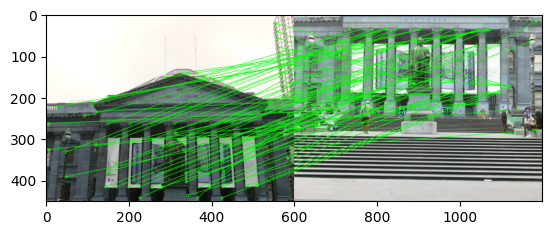

(<matplotlib.image.AxesImage at 0x11bcfebcd70>, None)

In [10]:
bf=cv2.BFMatcher()
matches= bf.knnMatch(img1_features, img2_features, k=2)

good = []
for m,n in matches:
    # if m.distance < 0.75*n.distance:
    good.append([m])

print(len(good))
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kf1,img2,kf2,good,None,matchColor=(0, 255, 0),flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

Feature Matching using my Code

My own implementation which is basically not useless anymore.

It now works

In [11]:
class FeaturePair:
    def __init__(self, features1, features2, coords1, coords2, threshold):
        self.features=features1
        self.features2= features2
        self.coords1=coords1
        self.coords2=coords2
        self.threshold=threshold

        self.size= len(features1)
        self.pairs=np.full(self.size, -1)
        self.closest_dist1= np.full(self.size, np.inf)
        self.closest_dist2= np.full(self.size, np.inf)

    def dist(self, f1, f2):
        size= len(f1)
        sum=0
        for i in range(size):
            sum+=(f1[i][0]-f2[i][0])**2
        return np.sqrt(sum)

    def check_feature(self, f2_i):
        for i in range(self.size):
            if  self.features2[f2_i] is not None:
                self.check_against(i, f2_i)

    def check_against(self, f1_i, f2_i):
        if self.features[f1_i] is None:
            return
        dist= self.dist(self.features[f1_i], self.features2[f2_i])
        
        if dist<self.closest_dist1[f1_i]:
            self.closest_dist2[f1_i]= self.closest_dist1[f1_i]
            self.closest_dist1[f1_i]=dist
            self.pairs[f1_i]=f2_i
        elif dist<self.closest_dist2[f1_i]:
            self.closest_dist2[f1_i]=dist

    def  compute_similarity(self):
        for i in range(len(self.features2)):
            self.check_feature(i)

    def get_feature_pairs(self):
        l1=[]
        l2=[]
        for i in range(self.size):
            if self.pairs[i]==-1:
                print("ERROR never filled in ", i)
                continue
            ratio=(self.closest_dist2[i]-self.closest_dist1[i])/self.closest_dist2[i]
            
            if  ratio>=self.threshold :
                print(ratio)
                l1.append(self.coords1[i])
                l2.append(self.coords2[self.pairs[i]])

        return [l1,l2]


In [12]:
closest_dist1= np.full(42, np.inf)
print(np.sqrt(100))
print((img1_features[0][0]))

10.0
[0.35172963]


In [13]:
#  __init__(self, features1, features2, coords1, coords2, threshold):
fp= FeaturePair(img1_features, img2_features, img1_top_n, img2_top_n, 0.3)
fp.compute_similarity()

feature_pairs= fp.get_feature_pairs()

0.5867722808772986
0.7091250852113409
0.8089897754641878
0.4311830337451959
0.6143610707090015
0.7869759761003507
0.46462382293326254
0.5920553347680584
0.44147735426432855
0.39414241099783287
0.4927847033307778
0.4221440378880626
0.7931990596058576
0.7396252832376269
0.350544268036982
0.46049089685672073
0.42842669143770823
0.40151212221899973
0.37570104317897196
0.8388970414201183
0.5141000413737841


In [14]:
print(len(feature_pairs))
print(len(img1_features))
print(len(img2_top_n))

2
80
80


int64 int64
(21, 2) (21, 2)


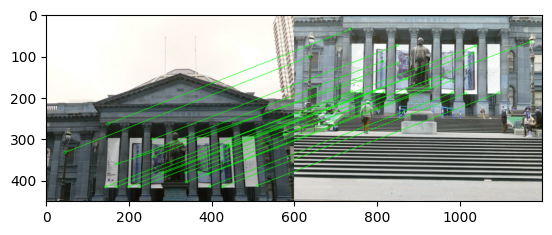

(<matplotlib.image.AxesImage at 0x11bcff982d0>, None)

In [15]:
# Visualising matches
# Transformation to use drawMatches

kf1,kf2= feature_pairs
kf1= np.array(kf1)
kf2= np.array(kf2)
print(kf1.dtype, kf2.dtype)
print(kf1.shape, kf2.shape)

# Transfer to keypoint
def keypoint(points):
	kp1 = []
	for i in range(len(points)):
		kp1.append(cv2.KeyPoint(int(points[i][1]), int(points[i][0]), 3))
	return kp1

kf1=keypoint(kf1)
kf2=keypoint(kf2)

def create_matches(num):
    m=[]
    for i in range(num):
        m.append(cv2.DMatch(i,i,2))
    return m

matches1to2=create_matches(len(kf2))


img3 = cv2.drawMatches(img1,kf1,img2,kf2,matches1to2,None,matchColor=(0, 255, 0),flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

TRYING RANSAC

In [16]:
import random

In [17]:
print(source_points.shape)

NameError: name 'source_points' is not defined

In [18]:
print(M.shape)
print(M)
coords=cv2.perspectiveTransform(np.array([[[100,100]],[[200,200]]]).astype(np.float32), M)
# reshaped= np.reshap
source_points=np.array(feature_pairs[0]).astype(np.float32)
destination_points=np.array(feature_pairs[1]).astype(np.float32)

print(coords.shape)
norm_of=np.expand_dims(destination_points, axis=1)-cv2.perspectiveTransform(np.expand_dims(source_points, axis=1),M)
new_norm_of= np.squeeze(norm_of)
diff= np.linalg.norm(new_norm_of, axis=1)
print(norm_of.shape, " Element 1-", norm_of[10])
print(new_norm_of.shape, " Element 1-", new_norm_of[10])
print(diff.shape, " Element 1-", diff[10])

NameError: name 'M' is not defined

In [61]:
def ransac(feature_pairs, threshold):
    H=[]
    inlier_count=[]
    source_points=np.array(feature_pairs[0])
    destination_points=np.array(feature_pairs[1])
    for i in range(100000):
        tot_features= len(source_points)
        random_indices= random.sample(range(0, tot_features),4)

        temp_source=source_points[random_indices]
        temp_destination=destination_points[random_indices]
        M= cv2.getPerspectiveTransform(temp_source, temp_destination)

        norm_of=np.expand_dims(destination_points, axis=1)-cv2.perspectiveTransform(np.expand_dims(source_points, axis=1),M)
        new_norm_of= np.squeeze(norm_of)
        diff= np.linalg.norm(new_norm_of, axis=1) #This is a vector of norms stacked on each other

        inliers_indices= np.argwhere(diff<threshold)
        H.append(inliers_indices) #Comment 
        # H.append(M) #Comment2 this
        inlier_count.append(len(inliers_indices))
    max_inliers_idx=np.argmax(inlier_count)
    print(inlier_count[max_inliers_idx])
    print(diff)
    source_points=np.squeeze(source_points[H[max_inliers_idx]])
    destination_points=np.squeeze(destination_points[H[max_inliers_idx]])
    print("Inliers-", inlier_count)
    # Stack up homography matrices for inliers and take their mean
    M=[]
    for i in range(len(source_points)//4):
        M.append(cv2.getPerspectiveTransform(source_points[i*4:i*(4)+4], destination_points[i*4:i*(4)+4]))
    M.append(cv2.getPerspectiveTransform(source_points[-4:], destination_points[-4:]))
    M= np.array(M)
    final_M=np.mean(M, axis=0)
    
    return final_M, [source_points, destination_points]

    # Comment 2
    # final_M= H[max_inliers_idx]
    # return final_M



In [62]:
source_points=np.array(feature_pairs[0]).astype(np.float32)
destination_points=np.array(feature_pairs[1]).astype(np.float32)

M,pairs= ransac([source_points, destination_points], 10)

20
[  66.443306    7.599051   96.324196 2319.3252    496.7032    101.91907
   51.74703     0.         39.64037    77.040276   87.10435   508.37613
    0.          8.305431   41.26665     0.         29.880966  101.436165
  194.82158     0.        113.60415 ]
Inliers- [19, 5, 7, 9, 20, 4, 7, 4, 8, 5, 4, 8, 15, 15, 4, 20, 17, 20, 13, 4, 13, 7, 7, 6, 16, 19, 16, 1, 16, 15, 17, 4, 19, 10, 7, 12, 15, 19, 5, 4, 12, 14, 10, 20, 16, 14, 19, 6, 4, 14, 9, 20, 6, 4, 14, 19, 20, 4, 11, 7, 20, 8, 5, 7, 9, 1, 9, 8, 20, 5, 19, 17, 20, 7, 4, 4, 5, 20, 20, 14, 4, 11, 15, 10, 9, 20, 9, 9, 15, 20, 4, 20, 7, 1, 9, 13, 14, 7, 10, 15, 15, 6, 8, 4, 7, 5, 5, 12, 20, 5, 15, 16, 4, 20, 20, 8, 9, 12, 16, 20, 13, 20, 13, 13, 4, 5, 18, 15, 20, 16, 14, 5, 15, 19, 17, 8, 16, 5, 5, 5, 20, 14, 6, 10, 20, 5, 15, 9, 19, 15, 4, 13, 19, 17, 20, 18, 6, 7, 20, 7, 20, 11, 8, 10, 20, 13, 4, 20, 5, 19, 4, 14, 14, 19, 8, 20, 5, 13, 20, 17, 8, 6, 4, 20, 16, 13, 20, 10, 11, 20, 4, 20, 18, 19, 17, 12, 13, 11, 16, 13, 20, 17, 20, 5,

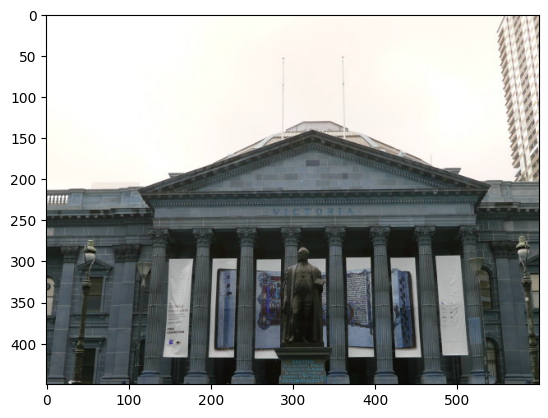

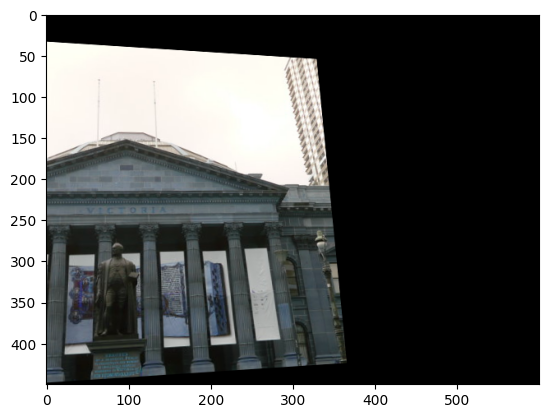

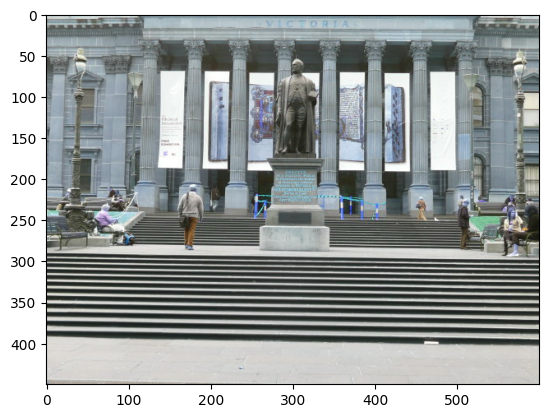

(<matplotlib.image.AxesImage at 0x11be5337750>, None)

In [63]:
# tot_features= len(feature_pairs[0])
# random_indices= [random.randint(0,4) for _ in range(tot_features)]

# source_points=[]
# destination_points=[]
# for i in range(4):
#     source_points.append(feature_pairs[0][random_indices[i]])
#     destination_points.append(feature_pairs[1][random_indices[i]])

# source_points=np.array(source_points).astype(np.float32)
# destination_points=np.array(destination_points).astype(np.float32)
# M= cv2.getPerspectiveTransform(source_points, destination_points)
img1= cv2.imread(image_path)
img2= cv2.imread(image_path2)

warped_image=cv2.warpPerspective(img1, M, (img1.shape[1], img1.shape[0]))


plt.imshow(img1),plt.show()
plt.imshow(warped_image),plt.show()
plt.imshow(img2),plt.show()

In [55]:
# Warp image
import cv2
import numpy as np

# Load the two images
image1 = img1  # Base image
image2 = img2  # Image to warp

# Assume homography matrix is known
H = M # Example homography matrix

# Get the height and width of the images
h1, w1 = image1.shape[:2]
h2, w2 = image2.shape[:2]

# Define the corners of the second image
corners_image2 = np.array([[0, 0], [w2, 0], [w2, h2], [0, h2]], dtype=np.float32).reshape(-1, 1, 2)

# Transform the corners of the second image using the homography matrix
transformed_corners = cv2.perspectiveTransform(corners_image2, H)

# Combine the corners of both images to calculate the bounding box of the stitched image
all_corners = np.vstack(([[0, 0], [w1, 0], [w1, h1], [0, h1]], transformed_corners.reshape(-1, 2)))

# Find the bounding box of the stitched image
[x_min, y_min] = np.int32(all_corners.min(axis=0))
[x_max, y_max] = np.int32(all_corners.max(axis=0))

# Calculate the size of the stitched canvas
translation = [-x_min, -y_min]  # Translation to move all points into positive space
stitched_width = x_max - x_min
stitched_height = y_max - y_min

# Create a translation matrix to shift the images
translation_matrix = np.array([[1, 0, translation[0]],
                                [0, 1, translation[1]],
                                [0, 0, 1]])

# Warp the second image using the homography matrix
warped_image2 = cv2.warpPerspective(image2, translation_matrix @ H, (stitched_width, stitched_height))

# Place the first image onto the canvas
stitched_image = warped_image2.copy()
stitched_image[translation[1]:translation[1] + h1, translation[0]:translation[0] + w1] = image1

# Display or save the stitched image
cv2.imshow("Stitched Image", stitched_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


ROUGH stuff

<class 'numpy.ndarray'>
(202, 2)


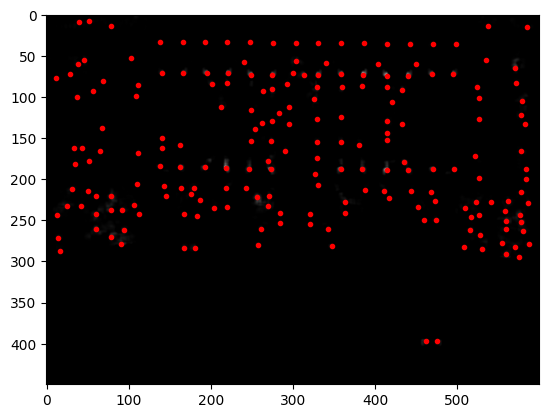

In [218]:
# Visualising corners of image2
# Visualising local maxima points
print(type(local_maximas2))
print(local_maximas2.shape)
plt.imshow(probab_corner2, cmap='gray')
plt.plot(local_maximas2[:, 1], local_maximas2[:, 0], 'r.')
plt.show()
